# Basic regression: Predict fuel efficiency

*Regression* and *Classification* algorithms are supervised learning algorithms. Both the algorithms are used for prediction and work with the labeled datasets. But the difference between both is how they are used for different machine learning problems.

The main difference is that regression algorithms are used to predict the continuous values such as price, salary, age, etc. Regression is thus a process of finding the correlations between dependent and independent variables. Classification algorithms, on the other hand, are used to predict/classify the discrete values such as Male or Female, True or False, Spam or Not Spam, etc. The goal is to train a model on the training dataset and based on that training, to categorize the data into different classes.

This notebook uses the classic [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg) and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles.

In [25]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0



## The Auto MPG dataset
The dataset is available from the [UCI Machine Learning](https://archive.ics.uci.edu/ml/) repository.


### Getting the data

First download the dataset by using the `keras.utils.get_file` function.

In [27]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

We will use the `pandas` library to work with the tabular data.

In [28]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [29]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

There are different ways to solve the problem of missing values (their approximation by average or replacement by other values, etc). In our case, we will throw out the instances that have the missing values.

In [30]:
dataset = dataset.dropna()

### Encoding categorical variables

Column `Origin` is a categorical variable and not numerical, as it contains the name of the location the car is coming from:
1. (USA)
2. (Europe)
3. (Japan)

In [31]:
# List unique values in a column (in 2 different ways)
print(dataset.Origin.unique())
print(dataset["Origin"].unique())

[1 3 2]
[1 3 2]


**TIP:** This is an extremely useful transformation in practice. We want to replace the column elements with some other values depending on the mapping we pass.

In [32]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

We perform dummy encoding of a categorical variable. This categorical data encoding method transforms the categorical variable into a set of binary variables (also known as dummy variables). In the case of one-hot encoding, for $N$ categories in a variable, it uses $N$ binary variables. So convert the `Origin` variable to a one-hot vector with `pd.get_dummies`.

In [33]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [34]:
# We choose 80% of the data as the training data
train_dataset = dataset.sample(frac=0.8,random_state=0)

# The rest 20% is used as the testing data
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

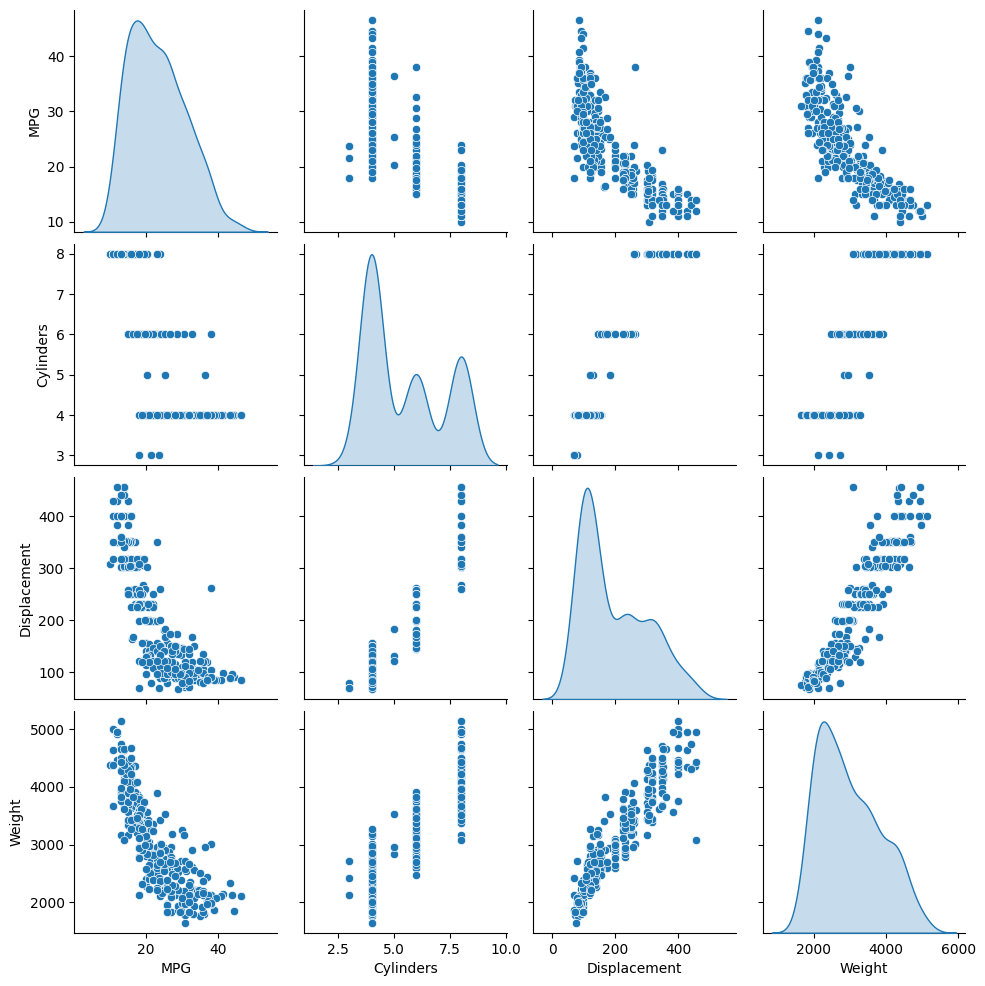

In [35]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics, note how each feature covers a different range. We omit the MPG as this is the target variable.

In [36]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Extract the target variable

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

So, we extract the target variable `MPG` from the data ([miles per gallon](https://www.carwow.co.uk/guides/running/what-is-mpg-0255)).

In [37]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

### Data standardization/normalization

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

In [38]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

**IMPORTANT:** Note that we use the average and standard deviation of the training set both when we standardize data for training **and** testing. This is important because we do not want to use the information from the test data set in any way when training the model because it introduces a bias that leads to customization. Check the notebooks from the previous Lab session.

## Regression model

### Defining the model

It is time to define our model. We will use the `Sequential` model which will represent one neural network with forward propagation. At the output of this network, there will be a neuron that will evaluate the attribute `MPG`.

As a function of the error, we will use the mean squared error.

Apart from the `Adam` optimizer, there are many others. For illustration, the `RMSprop` optimizer will be used here.

In [39]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [40]:
model = build_model()

### Model summary

Using the `summary` function we can look at an overview of the defined model.

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


We can test the model. We will take a subset of $10$ examples from the training set and pass them through the network.

In [42]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 63ms/step


array([[-0.49072376],
       [-0.15590927],
       [-0.8706918 ],
       [-0.17382956],
       [-0.5249119 ],
       [-0.2034338 ],
       [-0.5956981 ],
       [-0.02551481],
       [-0.29266873],
       [-0.6258621 ]], dtype=float32)

In [43]:
example_result.shape

(10, 1)

We get $10$ values as predictions.

### Training the model

We will divide the training set into two new sets, one will be the set where the training will actually take place (80% of the original training set), and we will use the validation set to evaluate how good our model is at the end of each epoch.

We will train the 1000 epoch model and keep the accuracy on the training and validation data during the training. The `fit` function returns an object that contains the necessary data.

In [44]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

Epoch 1/1000


/root/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 1s 59ms/step - loss: 585.5898 - mae: 23.0090 - mse: 585.5898 - val_loss: 576.6454 - val_mae: 22.8050 - val_mse: 576.6454
Epoch 2/1000
8/8 [==============================] - 0s 17ms/step - loss: 537.5260 - mae: 21.9735 - mse: 537.5260 - val_loss: 526.1609 - val_mae: 21.7053 - val_mse: 526.1609
Epoch 3/1000
8/8 [==============================] - 0s 12ms/step - loss: 490.2864 - mae: 20.9032 - mse: 490.2864 - val_loss: 471.8746 - val_mae: 20.4664 - val_mse: 471.8746
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 439.1236 - mae: 19.7019 - mse: 439.1236 - val_loss: 413.6168 - val_mae: 19.0594 - val_mse: 413.6168
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 383.7517 - mae: 18.3288 - mse: 383.7517 - val_loss: 350.0385 - val_mae: 17.3938 - val_mse: 350.0385
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 325.8119 - mae: 16.7374 - mse: 325.8119 - val_loss: 287.8451 - val_mae: 15.570

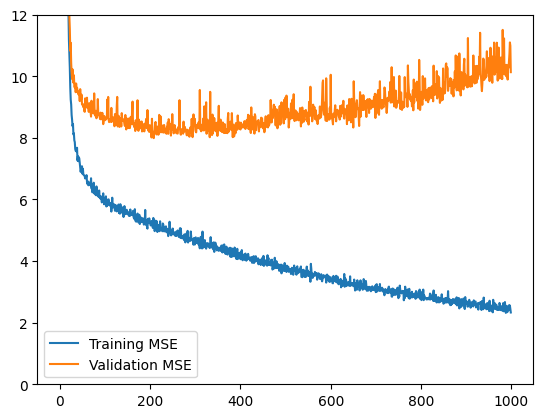

In [45]:
plt.plot(history.epoch, history.history['mse'])
plt.plot(history.epoch, history.history['val_mse'])
plt.ylim([0, 12])
plt.legend(['Training MSE', 'Validation MSE'])

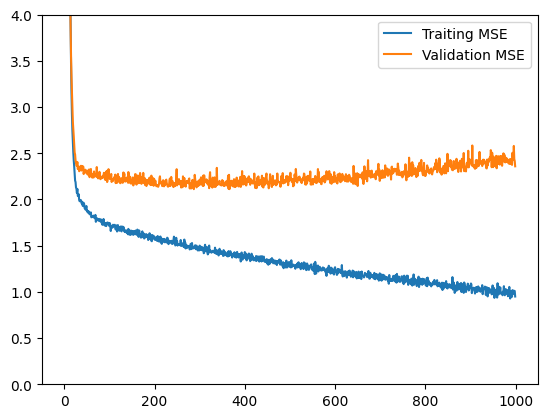

In [46]:
plt.plot(history.epoch, history.history['mae'])
plt.plot(history.epoch, history.history['val_mae'])
plt.ylim([0, 4])
plt.legend(['Traiting MSE', 'Validation MSE'])

The obtained data can be visualized using the `pandas` library.
`DataFrame` is a `pandas` type that represents tabular data.

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# We take the last 5 rows
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.565335,0.979631,2.565335,10.492025,2.427686,10.492025,995
996,2.421729,1.012768,2.421729,10.725246,2.579368,10.725246,996
997,2.557753,1.009295,2.557753,11.099282,2.437108,11.099282,997
998,2.442127,1.009840,2.442127,10.990181,2.416986,10.990181,998
999,2.331033,0.949889,2.331033,10.133658,2.358954,10.133658,999


We can notice that 1000 epochs is too much and that releasing training to last that long does not contribute to the accuracy of the model. We will repeat the optimization process again, but this time we will use the technique of **early stopping**.

The idea is to define a set of constraints that, once fulfilled, model training will be stopped. For example, if the value of `val_mse` does not improve in `k` consecutive epochs, it makes sense to stop training.

How to determine the `k` parameter? It is a similar problem as how to determine the network architecture, optimizer etc.

More about `EarlyStopping` can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [48]:
model = build_model()

# Parameter `patience` is the number of epoch that is considered for the early stopping.
# Parameter `monitor` represents the measure that is being compared through the epoch.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split=0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/1000


/root/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 1s 25ms/step - loss: 567.5273 - mae: 22.5883 - mse: 567.5273 - val_loss: 559.4209 - val_mae: 22.3996 - val_mse: 559.4209
Epoch 2/1000
8/8 [==============================] - 0s 8ms/step - loss: 520.6491 - mae: 21.5615 - mse: 520.6491 - val_loss: 508.6325 - val_mae: 21.2658 - val_mse: 508.6325
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 471.9329 - mae: 20.4360 - mse: 471.9329 - val_loss: 451.7480 - val_mae: 19.9212 - val_mse: 451.7480
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 417.3893 - mae: 19.1054 - mse: 417.3893 - val_loss: 388.7715 - val_mae: 18.3335 - val_mse: 388.7715
Epoch 5/1000
8/8 [==============================] - 0s 15ms/step - loss: 357.0588 - mae: 17.5395 - mse: 357.0588 - val_loss: 320.3731 - val_mae: 16.4726 - val_mse: 320.3731
Epoch 6/1000
8/8 [==============================] - 0s 14ms/step - loss: 294.5889 - mae: 15.7567 - mse: 294.5889 - val_loss: 253.8036 - val_mae: 14.423

Text(0, 0.5, 'MAE [MPG]')

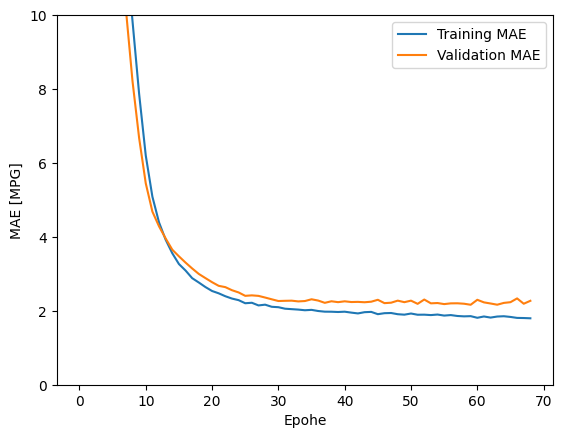

In [49]:
plt.plot(early_history.epoch, early_history.history['mae'])
plt.plot(early_history.epoch, early_history.history['val_mae'])
plt.ylim([0, 10])
plt.legend(['Training MAE', 'Validation MAE'])
plt.xlabel('Epohe')
plt.ylabel('MAE [MPG]')

The graph shows that at the validation set, the average error is about $\pm 2$ MPG. Whether this is good or not depends on the measure and the case of use, which depends on the problem.

### Model evaluation

The next thing we will do is look at how well the model generalizes on the test data.

Here things get a little complicated. It should be borne in mind that we have so far trained the model in a subset (80%) of the training set in order to have a validation set. There is no point in throwing away data (20% of training data that ended up as validation data), so we will re-train the model, but now we have the entire training data, and we will use **THAT** model for evaluation at the test set.

The question is how many epochs to set for training? One approach is to set the number of epochs taken at an early stop. At the time of writing, in this example it was 59.

In [50]:
model = build_model()

early_stop_epochs = 59

final_history = model.fit(normed_train_data, train_labels, 
                    epochs=early_stop_epochs, verbose=1)

Epoch 1/59
10/10 [==============================] - 1s 5ms/step - loss: 553.5060 - mae: 22.2535 - mse: 553.5060
Epoch 2/59
10/10 [==============================] - 0s 7ms/step - loss: 472.5703 - mae: 20.4200 - mse: 472.5703
Epoch 3/59
10/10 [==============================] - 0s 7ms/step - loss: 391.6536 - mae: 18.4048 - mse: 391.6536
Epoch 4/59
10/10 [==============================] - 0s 7ms/step - loss: 309.7092 - mae: 16.1479 - mse: 309.7092
Epoch 5/59
10/10 [==============================] - 0s 7ms/step - loss: 229.6729 - mae: 13.6784 - mse: 229.6729
Epoch 6/59
10/10 [==============================] - 0s 7ms/step - loss: 158.5513 - mae: 11.1855 - mse: 158.5513
Epoch 7/59
10/10 [==============================] - 0s 7ms/step - loss: 101.2400 - mae: 8.6650 - mse: 101.2400
Epoch 8/59
10/10 [==============================] - 0s 7ms/step - loss: 62.6238 - mae: 6.5851 - mse: 62.6238
Epoch 9/59
10/10 [==============================] - 0s 7ms/step - loss: 41.2889 - mae: 5.1056 - mse: 41.2889

Finally, we can look at how our model behaves at the test set.

In [51]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
rmse_test = np.sqrt(mse)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Root of the Mean Squared Errorr: {:5.2f} MPG".format(rmse_test))

3/3 - 0s - loss: 5.3057 - mae: 1.7646 - mse: 5.3057 - 121ms/epoch - 40ms/step
Testing set Mean Abs Error:  1.76 MPG
Testing set Root of the Mean Squared Errorr:  2.30 MPG


We get 1.82 MPG mean absolute error, which is not bad. Interestingly, it is even less than the validation error. This is also reasonable because we are now using more data.

### Predicting values in the future

Is it over? Yes and no, it depends on different things. If we are satisfied with this model and want to move it into production and use it, there is no point in throwing away the data that exists in the test set.

It makes sense to retrain the model, now over all the data. How do we then evaluate that model? We will not evaluate it. If we conducted this process well, the error in the test set gives us an approximation of the quality of this final model that we trained over the entire dataset.

The machine learning community is making efforts to standardize network storage formats. One of them is [ONNX](https://onnx.ai/) for which the Keras library offers [support](https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/converter_scripts/keras_onnx.ipynb). 

This notebook is partially based on the official [Basic regression: Predict fuel efficiency
](https://www.tensorflow.org/tutorials/keras/regression) Tensorflow tutorial.